In [1]:
# Import table and plot packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#import logistic regression 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.dummy import DummyClassifier
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# import feature engineer tools
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree

%matplotlib inline

In [2]:
# reading train data
trainDF = pd.read_csv("./data/train.csv")

### Exploratory analysis

#### Plot the number of survived (1) and died (0) passengers

In [3]:
groupSurv = trainDF.groupby(['Survived'])#, as_index=False)
numSurvDied = groupSurv.count()
numSurvDied.reset_index(inplace=True)

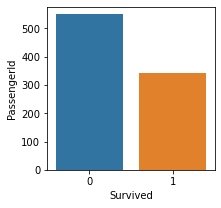

In [4]:
fig, ax = plt.subplots(1, 1, figsize= (3,3))
barPlt = sns.barplot(x='Survived', y='PassengerId', data=numSurvDied, ax=ax)

#### Proportion of survived in 1st with respect to 1st passengers

In [5]:
firstCl = trainDF.loc[trainDF['Pclass'] == 1]
numFC = firstCl['Pclass'].value_counts()
survFC = (firstCl['Survived']==1).value_counts()[1] #take the value that evaluates to true
#print(survFC)
propSurvFC = survFC /numFC
#propSurvFC

#### Plot bar: numbers of passengers per class (1, 2, 3) divided per sex

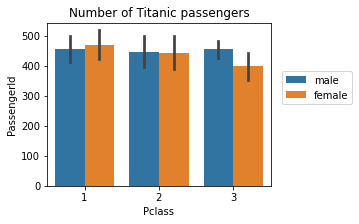

In [6]:
fig, ax = plt.subplots(1, 1, figsize= (4,3))
plt.title('Number of Titanic passengers')
barPass = sns.barplot(x='Pclass', y='PassengerId', data=trainDF, hue='Sex', ax = ax)
ax.legend(loc = (1.05,0.5))

#### Plot comparison suvived/not survived for all passengers (all classes, all sex, all ages)

<AxesSubplot:xlabel='Age', ylabel='Count'>

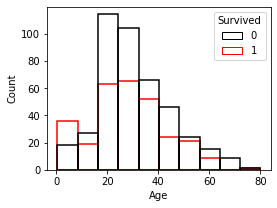

In [7]:
fig, ax = plt.subplots(1, 1, figsize= (4,3))
sns.histplot(data=trainDF, x='Age', bins=10, hue='Survived', element ='bars', fill=False,
            cbar = True, alpha=0.7, palette=['black', 'red'], ax=ax)

#### age-average for surived and for not survived passengers

In [8]:
meanAge = groupSurv['Age'].mean()
meanAgeSurv =  round(meanAge[1], 2)
meanAgeDied = round(meanAge[0], 2)
#print('Mean age survived:', meanAgeSurv)
#print('Mean age died:', meanAgeDied)

#### replace missing age

In [9]:
trainDF['Age'] = trainDF["Age"].fillna(0)

In [10]:
survNotAge = (trainDF["Survived"] == 1) & (trainDF["Age"] == 0)
diedNotAge = (trainDF["Survived"] == 0) & (trainDF["Age"] == 0)
trainDF.loc[survNotAge, "Age"] = meanAgeSurv
trainDF.loc[diedNotAge, "Age"] = meanAgeDied

Step 8: create a table counting  number of surv-dead separatelly for 1st, 2st, 3st

In [11]:
classSexSurvGR = trainDF.groupby(['Pclass', 'Sex', 'Survived'], as_index=False)
classSexSurvGR['PassengerId'].count()

,Pclass,Sex,Survived,PassengerId
0,1,female,0,3
1,1,female,1,91
2,1,male,0,77
3,1,male,1,45
4,2,female,0,6
5,2,female,1,70
6,2,male,0,91
7,2,male,1,17
8,3,female,0,72
9,3,female,1,72


#### Build a baseline model with DummyClassifier

In [12]:
X = trainDF[["Pclass"]]
y = trainDF["Survived"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
#print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)

In [14]:
dum_m = DummyClassifier(strategy = 'most_frequent')

In [15]:
dum_m.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

#### Calculate performance of dummy model

In [16]:

y_pred_train = dum_m.predict(X_train)
acc_train_dummy_mf = metrics.accuracy_score(y_train, y_pred_train)
print(acc_train_dummy_mf)

0.6107784431137725


In [17]:
y_pred_test = dum_m.predict(X_test)
acc_test_dummy_mf = metrics.accuracy_score(y_pred_test, y_test)
print(acc_test_dummy_mf)

0.6322869955156951


In [18]:
#Same dummy test but with strategy= stratified
dum_m = DummyClassifier(strategy = 'stratified')

In [19]:
dum_m.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

In [20]:
y_pred_train = dum_m.predict(X_train)
acc_train_dummy_st = metrics.accuracy_score(y_train, y_pred_train)
print(acc_train_dummy_st)

0.5449101796407185


In [21]:
y_pred_test = dum_m.predict(X_test)
acc_test_dummy_st = metrics.accuracy_score(y_pred_test, y_test)
print(acc_test_dummy_st)

0.5426008968609866


* Note: the dummy model with strategy= stratified perfoms
   worst than the dummy model with strategy= most_frequent!

In [22]:
#Same dummy test but with strategy= uniform
dum_m = DummyClassifier(strategy = 'uniform')
dum_m.fit(X_train, y_train)

y_pred_train = dum_m.predict(X_train)
acc_train_dummy_un = metrics.accuracy_score(y_train, y_pred_train)
print(acc_train_dummy_un)

y_pred_test = dum_m.predict(X_test)
acc_test_dummy_un = metrics.accuracy_score(y_pred_test, y_test)
print(acc_test_dummy_un)

0.5119760479041916
0.5112107623318386


Text(0.5, 1.0, 'Accuracy of Dummy Classifier for 3 different strategies')

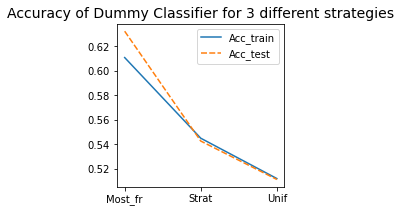

In [23]:
acc_dum_tr_data = {'Acc_train' : [acc_train_dummy_mf, acc_train_dummy_st, acc_train_dummy_un],
                  'Acc_test' : [acc_test_dummy_mf, acc_test_dummy_st, acc_test_dummy_un]}
labels = ['Most_fr', 'Strat', 'Unif']

accDumDF = pd.DataFrame(acc_dum_tr_data, index=labels)
fig, ax = plt.subplots(figsize = (3,3))
sns.lineplot(data=accDumDF)
plt.title('Accuracy of Dummy Classifier for 3 different strategies', size=14)

* It seems that the best dummy model is the one that uses strategy=most_frequent

#### Train the LogReg model 

1) Only one feature: Pclass

In [24]:
# Create the model
logReg_m = LogisticRegression(class_weight='balanced')

In [25]:
# X and y are the same as before
logReg_m.fit(X, y)

LogisticRegression(class_weight='balanced')

In [26]:
# Check the calculated wights w and bias b
w = logReg_m.coef_
b = logReg_m.intercept_
print('w =', w, 'and b =', b)

w = [[-0.84849995]] and b = [1.91625131]


In [27]:
# Prediction training data and accuracy calculation
y_pred_train = logReg_m.predict(X_train)
acc_train_onlyPclass = metrics.accuracy_score(y_pred_train, y_train)
print(acc_train_onlyPclass)

0.6766467065868264


In [28]:
# Prediction test data and accuracy
y_pred_test = logReg_m.predict(X_test)
acc_test_onlyPclass = metrics.accuracy_score(y_pred_test, y_test)
print(acc_test_onlyPclass)

0.6412556053811659


In [29]:
# Calculation of probability of results
prob_train_onlyPclass = logReg_m.predict_proba(X_train)

#prob_train_t = prob_train.transpose()
#len(prob_train_t[0])

In [30]:
prob_test_onlyPclass = logReg_m.predict_proba(X_test)
#prob_test

#### Try other thresholds and compare with 0.5 (using accuracy)

In [31]:
def compareTestAccur_bythres(firstTr, secondTr, prob):
    pred_trfirst = np.where(prob[:, 1] >= firstTr, 1 , 0)
    pred_trsec = np.where(prob[:, 1] >= secondTr, 1 , 0)
    acc_first = metrics.accuracy_score(pred_trfirst, y_test)
    acc_sec = metrics.accuracy_score(pred_trsec, y_test)
    if acc_first >= acc_sec:
        print("Threshold =", firstTr, "prefoms better than", secondTr)
    else:
        print("Threshold =", firstTr, "prefoms worst than", secondTr)

In [32]:
compareTestAccur_bythres(0.9, 0.5, prob_test_onlyPclass)
compareTestAccur_bythres(0.1, 0.5, prob_test_onlyPclass)
compareTestAccur_bythres(0.1, 0.9, prob_test_onlyPclass)

Threshold = 0.9 prefoms worst than 0.5
Threshold = 0.1 prefoms worst than 0.5
Threshold = 0.1 prefoms worst than 0.9


#### Compare logReg_m accuracy with DummyClassifier accuracy
* The Logistic regression model wins!

In [33]:
print('DummyClassifier accuracy (most_frequent) for test data =', acc_test_dummy_mf)
print('LogisticRegression accuracy for test data =', acc_test_onlyPclass)

DummyClassifier accuracy (most_frequent) for test data = 0.6322869955156951
LogisticRegression accuracy for test data = 0.6412556053811659


#### Adding features: Age and sex of passengers

In [34]:
trainDF.tail(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,30.63,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.00,0,0,370376,7.75,NaN,Q


In [35]:
# convert sex to binary: 0 male, 1 female
trainDF["Sex"] = np.where(trainDF["Sex"] == 'female', 1, 0)
#trainDF.head(5)

In [36]:
X = trainDF[["Pclass", "Age", "Sex"]]
y = trainDF["Survived"]
print(X.shape, y.shape)
X.head()

(891, 3) (891,)


,Pclass,Age,Sex
0,3,22.0,0
1,1,38.0,1
2,3,26.0,1
3,1,35.0,1
4,3,35.0,0


In [37]:
# splitting again into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [38]:
#fit again the logistic regression model (logReg_m already instantiated)
logReg_m.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [39]:
ws, b = logReg_m.coef_, logReg_m.intercept_
print('weights:\nw1 =', ws[0][0], 
      '\nw2=', ws[0][1], 
      '\nw3 =', ws[0][2], 
      '\nintercept:\nb', b[0])

weights:
w1 = -0.8988321597383074 
w2= -0.03232263852414753 
w3 = 2.428988647794421 
intercept:
b 2.069103764185292


In [40]:
# Prediction training data and accuracy calculation
y_pred_train = logReg_m.predict(X_train)
acc_train_class_age_sex = metrics.accuracy_score(y_pred_train, y_train)
print(acc_train_class_age_sex)

0.7784431137724551


In [41]:
# Prediction test data and accuracy calculation
y_pred_test = logReg_m.predict(X_test)
acc_test_class_age_sex = metrics.accuracy_score(y_pred_test, y_test)
print(acc_test_class_age_sex)

0.820627802690583


* The model trained with 3 features (passenger class, age and sex) performs
 better than model trained with only one feature (Pclass)
* For training data : 3 features metod is 18.2% better than 1 feature method
* For test data : 3 features metod is 22.2% better than 1 feature method

15.04 27.97


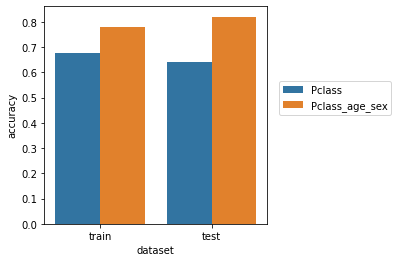

In [42]:
accs_data = {'dataset': ['train', 'train', 'test', 'test'],
             'accuracy' : [acc_train_onlyPclass, acc_train_class_age_sex,
                           acc_test_onlyPclass, acc_test_class_age_sex],
             'used_feats': ['Pclass', 'Pclass_age_sex', 'Pclass', 'Pclass_age_sex']}
accDF = pd.DataFrame(accs_data)
accDF
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(data=accDF, x='dataset', y='accuracy', hue='used_feats', ax=ax)
ax.legend(loc = (1.05,0.5))
acc_diff_train = (acc_train_class_age_sex - acc_train_onlyPclass)*100/acc_train_onlyPclass
acc_diff_test = (acc_test_class_age_sex-acc_test_onlyPclass)*100/acc_test_onlyPclass
print(round(acc_diff_train, 2), round(acc_diff_test,2))

### From here working with model trained with 3 features

In [43]:
# calculate precision and recall
metrics.confusion_matrix(y_test, y_pred_test)

array([[106,  27],
       [ 13,  77]])

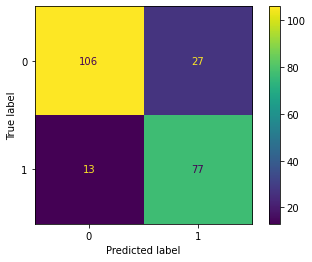

In [44]:
metrics.plot_confusion_matrix(logReg_m, X_test, y_test, normalize=None)

In [45]:
prec_class_age_sex = metrics.precision_score(y_test, y_pred_test, pos_label=1)
prec_class_age_sex

0.7403846153846154

In [46]:
rec_class_age_sex = metrics.recall_score(y_test, y_pred_test, pos_label=1)
rec_class_age_sex

0.8555555555555555

#### Draw a ROC curve or precision-recall plot

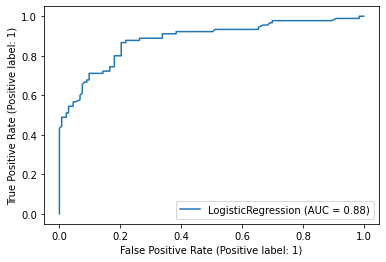

In [47]:
metrics.plot_roc_curve(logReg_m, X_test, y_test)

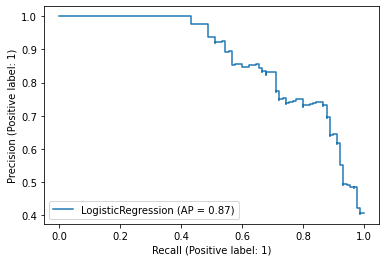

In [48]:
metrics.plot_precision_recall_curve(logReg_m, X_test, y_test)

#### Plot prediction for training and test dataset

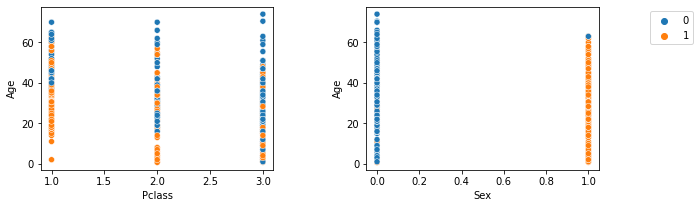

In [49]:
# plot Pclasse vs age and Sex vs age for  training
fig, axs = plt.subplots(1,2, figsize=(10,3))
sns.scatterplot(data = X_train, x="Pclass", y="Age", hue = y_pred_train, ax =axs[0], legend=None)
#sns.scatterplot(data = X_train, x="Pclass", y="Sex", hue = y_pred_train, ax =axs[1], legend=None)
sns.scatterplot(data = X_train, x="Sex", y="Age", hue = y_pred_train, ax =axs[1])
axs[1].legend(loc='center left', bbox_to_anchor=(1.2, 0.87), ncol=1)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)

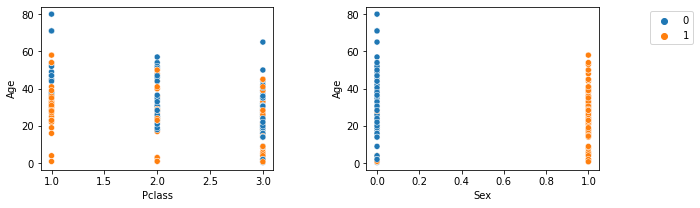

In [50]:
# plot Pclasse vs age and Sex vs age for  training
fig, axs = plt.subplots(1,2, figsize=(10,3))
sns.scatterplot(data = X_test, x="Pclass", y="Age", hue = y_pred_test, ax =axs[0], legend=None)
#sns.scatterplot(data = X_test, x="Pclass", y="Sex", hue = y_pred_test, ax =axs[1], legend=None)
sns.scatterplot(data = X_test, x="Sex", y="Age", hue = y_pred_test, ax =axs[1])
axs[1].legend(loc='center left', bbox_to_anchor=(1.2, 0.87), ncol=1)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)

#### Decision boundary for Pclass and age

In [51]:
sub_X_train = X_train[['Pclass', 'Age']]
# y_train is already defined

#### Train a DecisionTreeClassifier


In [52]:
DTC_model = DecisionTreeClassifier(max_depth= 4)
DTC_model.fit(sub_X_train, y_train)

LogReg_model = LogisticRegression()
LogReg_model.fit(sub_X_train, y_train)

LogisticRegression()

In [53]:
#step size for the mesh
h = 0.01

In [54]:
sub_X_train.head(3)

,Pclass,Age
62,1,45.0
498,1,25.0
500,3,17.0


#### plotting decision regions for training data

In [55]:

x_min, x_max = sub_X_train['Pclass'].min() - 1, sub_X_train['Pclass'].max() + 1
y_min, y_max = sub_X_train['Age'].min() - 5, sub_X_train['Age'].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

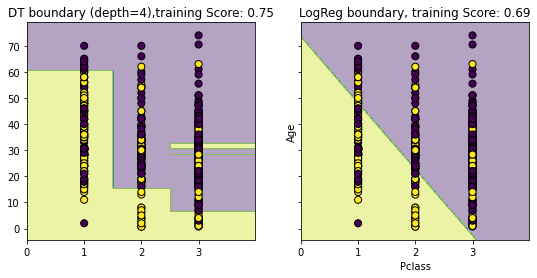

In [56]:
f, axs = plt.subplots(1,2, sharex='col', sharey='row', figsize=(9,4))
Xgrid = np.c_[xx.ravel(), yy.ravel()]
Z = DTC_model.predict(Xgrid)
ZlogReg = LogReg_model.predict(Xgrid)

#put results into a color plot
Z = Z.reshape(xx.shape)
ZlogReg = ZlogReg.reshape(xx.shape)
axs[0].contourf(xx, yy, Z, alpha=0.4)
axs[1].contourf(xx, yy, ZlogReg, alpha=0.4)

#plot the training points
axs[0].scatter(sub_X_train["Pclass"], sub_X_train["Age"], c=y_train, s=50, edgecolors='k' )
axs[0].set_title(f'DT boundary (depth=4),training Score: {round(DTC_model.score(sub_X_train, y_train),2)}')

axs[1].scatter(sub_X_train["Pclass"], sub_X_train["Age"], c=y_train, s=50, edgecolors='k' )
axs[1].set_title(f'LogReg boundary, training Score: {round(LogReg_model.score(sub_X_train, y_train),2)}')
plt.xlabel('Pclass')
plt.ylabel('Age')

plt.show()

#### plotting decision regions for test data

In [57]:
sub_X_test = X_test[['Pclass', 'Age']]
x_min, x_max = sub_X_test['Pclass'].min() - 1, sub_X_test['Pclass'].max() + 1
y_min, y_max = sub_X_test['Age'].min() - 5, sub_X_test['Age'].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

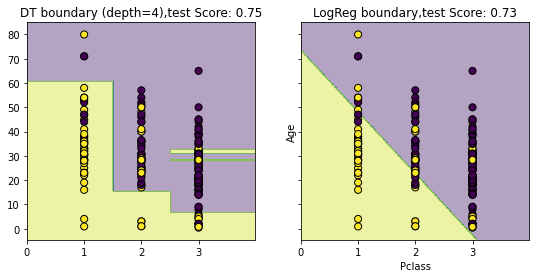

In [58]:
f, axs = plt.subplots(1,2, sharex='col', sharey='row', figsize=(9,4))
Xgrid = np.c_[xx.ravel(), yy.ravel()]
Z = DTC_model.predict(Xgrid)
ZlogReg = LogReg_model.predict(Xgrid)

#put results into a color plot
Z = Z.reshape(xx.shape)
ZlogReg = ZlogReg.reshape(xx.shape)
axs[0].contourf(xx, yy, Z, alpha=0.4)
axs[1].contourf(xx, yy, ZlogReg, alpha=0.4)

#plot the training points
axs[0].scatter(sub_X_test["Pclass"], sub_X_test["Age"], c=y_test, s=50, edgecolors='k' )
axs[0].set_title(f'DT boundary (depth=4),test Score: {round(DTC_model.score(sub_X_test, y_test),2)}')
axs[1].scatter(sub_X_test["Pclass"], sub_X_test["Age"], c=y_test, s=50, edgecolors='k' )
axs[1].set_title(f'LogReg boundary,test Score: {round(LogReg_model.score(sub_X_test, y_test),2)}')
plt.xlabel('Pclass')
plt.ylabel('Age')

plt.show()

In [59]:
trainDF.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C


#### Check if there are missing values in some colum
* Only columns "Cabin" and "Embarked" have missing values

In [60]:
cols = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age',
        'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
for col in cols:
    print(col, '\t\t missed values?\t\t', trainDF[col].isnull().values.any())
trainDF.isna().sum()

PassengerId 		 missed values?		 False
Survived 		 missed values?		 False
Pclass 		 missed values?		 False
Name 		 missed values?		 False
Sex 		 missed values?		 False
Age 		 missed values?		 False
SibSp 		 missed values?		 False
Parch 		 missed values?		 False
Ticket 		 missed values?		 False
Fare 		 missed values?		 False
Cabin 		 missed values?		 True
Embarked 		 missed values?		 True


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Check The types in columns
* Are all numbers except "Name", "Ticket", "Cabin", "Embarked"

In [61]:
trainDF.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [62]:
trainDF['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

#### Feature Engineering
* The column embarked has some missing value and, the non missing values, are categorical (S, C Q):
 * SimpleImputer (most_frequent) + OneHotEncoder
* The column "Age" is metric and is complete (we added missing value before!)
 * KBinsDiscretizer ('kids', 'youngs', 'adults', 'old')
* Cabin has too many missing values (687 missing values)
 * Drop it
* SibSp and parch are complete (SibSp number of sibblings/spouse parch n children/parents)
 * An idea could be to sum the two columns because they are related to relatives
 * Maybe then to make a KBinsI=Discretizer ('small', 'norm', 'big') uniform
* Fare is complete and metric
 * MinMaxScaler or two transformations: power the fare with Pclass (FuncTrans) and than scale with MinMax
* Ticket: what to do with ticket number? Does it contain some info? How to extract it?
 * drop
* Name of passenger: does it contain some info useful to survive or die?
 * drop or use the suggestion in course: FuncTrans to count the lengths

In [63]:
y = trainDF['Survived']
X = trainDF

In [64]:
#### sum SibSp and Parch columns
X['num_relatives'] = X['Parch'] + X['SibSp']

#### Split into train and test data

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [66]:
# imputer and oneHotEncode that we use later for "Embarked"
impute_and_encode = make_pipeline(
                            SimpleImputer(strategy= 'most_frequent'),
                            OneHotEncoder(sparse = False))

In [67]:
def mod_Fare(df):
    c = df[df.columns[0]]
    return (df[df.columns[1]]**(1/c)).values.reshape(-1,1)

In [68]:
# power and scale to be applied to fares
modFare_and_scale = make_pipeline(
                            FunctionTransformer(mod_Fare),
                            MinMaxScaler())

In [69]:
# add self defined function
def name_length(df):
    length = df[df.columns[0]].str.len()
    return length.values.reshape(-1, 1)

In [70]:
# Initialize ColumnTransformer
feat_eng = ColumnTransformer(
        [ #('fareScaled', MinMaxScaler(), ['Fare']),
          ('binsAge', KBinsDiscretizer(n_bins=3, encode='onehot-dense', strategy='uniform'), ['Age']),
          ('notDrop', 'passthrough', ['Sex']),
          #('notDropRel', 'passthrough', ['num_relatives']),
          ('binsRel', KBinsDiscretizer(n_bins=3, encode='onehot-dense', strategy='uniform'), ['num_relatives']),
          #('HotClass', OneHotEncoder(sparse=False), ['Pclass']),
          #('nameLength', FunctionTransformer(name_length), ['Name']),
          #('modFares', FunctionTransformer(mod_Fare), ['Pclass', 'Fare']),
          ('pip_fares', modFare_and_scale, ['Pclass', 'Fare']),
          #('HotEmbarked', impute_and_encode, ['Embarked']),                    
        ],
        remainder = 'drop')

In [71]:
X_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,num_relatives
670,671,1,2,"Brown, Mrs. Thomas William Solomon (Elizabeth ...",1,40.00,1,1,29750,39.0,NaN,S,2
868,869,0,3,"van Melkebeke, Mr. Philemon",0,30.63,0,0,345777,9.5,NaN,S,0
183,184,1,2,"Becker, Master. Richard F",0,1.00,2,1,230136,39.0,F4,S,3


In [72]:
# fit the ColumnTransformer
feat_eng.fit(X_train)
# tranform
X_train_trans =  feat_eng.transform(X_train)

In [73]:
X_train_transDF = pd.DataFrame(X_train_trans)
X_train_transDF.head(3)

,0,1,2,3,4,5,6,7
0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.012189
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.004134
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.012189


In [74]:
#feat_eng.named_transformers_['fareScaled']

In [75]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_trans, y_train)

LogisticRegression(max_iter=10000)

In [76]:
# transform also the test data
X_test_trans = feat_eng.transform(X_test)
# prediction
y_pred = model.predict(X_test_trans)

In [77]:
acc_LogReg = metrics.accuracy_score(y_test, y_pred)
acc_LogReg

0.8251121076233184

#### Implementing a decision treee classifier

In [78]:
DT_model = DecisionTreeClassifier(max_depth=3)
DT_model.fit(X_train_trans, y_train)

DecisionTreeClassifier(max_depth=3)

In [79]:
# predict test data
y_pred_DT = DT_model.predict(X_test_trans)

In [80]:
# evaluate the model
acc_DT = metrics.accuracy_score(y_test, y_pred_DT)
acc_DT

0.820627802690583

In [81]:
# what columns and how many columns does my training dataframe 
X_train_transDF.columns
X_train_transDF
feats = list(X_train_transDF.columns[0:])
feats = [str(x) for x in feats]
print(feats)

['0', '1', '2', '3', '4', '5', '6', '7']


In [82]:
# what classes predicts my models?
DT_model.classes_
cn = DT_model.classes_
cn = [str(x) for x in cn]
print(cn)

['0', '1']


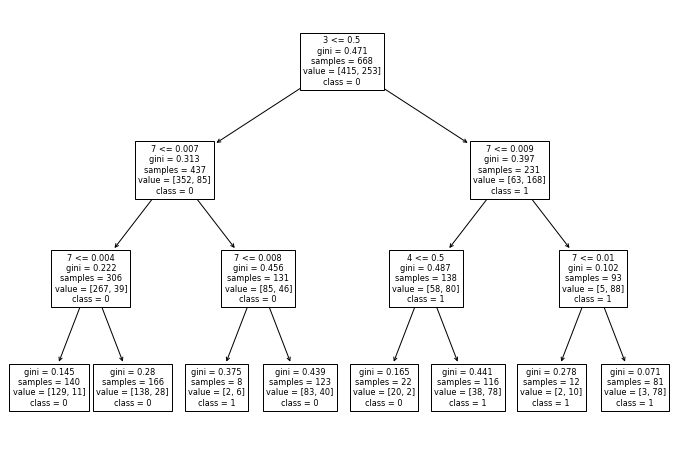

In [83]:
# plot the decision tree
plt.figure(figsize=(12,8))
t = plot_tree(DT_model, feature_names=feats, class_names=cn)

In [84]:
# check importance of features
DT_model.feature_importances_

array([0.        , 0.        , 0.        , 0.67710346, 0.0987132 ,
       0.        , 0.        , 0.22418335])

#### Implementing Random Forest

In [85]:
rfc = RandomForestClassifier(n_estimators=300)

In [86]:
rfc.fit(X_train_trans, y_train)

RandomForestClassifier(n_estimators=300)

In [87]:
# pediction
y_pred_RF = rfc.predict(X_test_trans)

In [88]:
# evaluation
acc_RF = metrics.accuracy_score(y_test, y_pred_RF)
acc_RF

0.8161434977578476

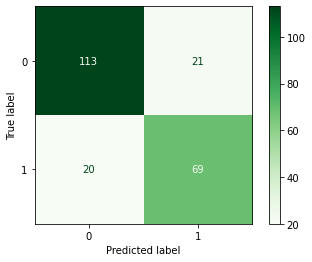

In [89]:
metrics.plot_confusion_matrix(rfc, X_test_trans, y_test, cmap=plt.cm.Greens)

In [90]:
importance =rfc.feature_importances_

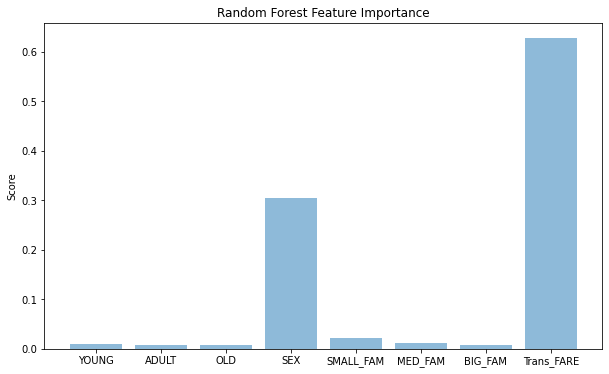

In [91]:
fig = plt.figure(figsize=(10,6))

plt.bar([x for x in range(len(importance))], importance, alpha=0.5 )
plt.title('Random Forest Feature Importance')
x = np.array([0,1,2,3,4,5,6,7])
my_xticks = ['YOUNG', 'ADULT', 'OLD',
                        'SEX', 'SMALL_FAM', 'MED_FAM',
                        'BIG_FAM', 'Trans_FARE']


plt.xticks(x, my_xticks)              #Feature 0: Culmen_depth
                                                                  # Feature 1: Culmen_length
plt.ylabel('Score')
plt.show()

#### Accuracy compraison between LogReg, DecTree and RandFor

In [92]:
# comparison LogReg, DecTree and RandFor
models_accs =[acc_LogReg, acc_DT, acc_RF]
models_accs

[0.8251121076233184, 0.820627802690583, 0.8161434977578476]

Text(0, 0.5, 'Accuracy')

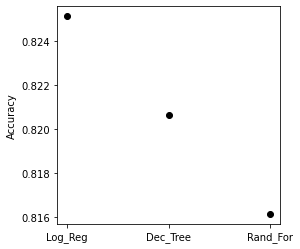

In [93]:
fig, ax = plt.subplots(figsize=(4,4))
plt.plot(models_accs, 'ko')
x = np.array([0,1,2])
my_xticks = ['Log_Reg', 'Dec_Tree', 'Rand_For']
plt.xticks(x, my_xticks)
plt.ylabel('Accuracy')

### Since the Logatimic Regression perfomed better than the other ones, I used it for submitting results in Kaggle (actual score 0.7751)


#### Cross validation

In [94]:
m = RandomForestClassifier(n_estimators=100, max_depth=4, n_jobs=1)

In [95]:
cv_results = cross_validate(
    estimator = m,             # the model you want to evaluate 
    X = X_train_trans,         # the training input data 
    y = y_train,               # the training output data  
    cv = 5,                    # number of cross validation datasets 
    scoring = 'accuracy',               # evaluation metric, also list
    return_train_score = True,   # return both the score on the training and the cross validated data
    n_jobs = 2                   # n_jobs = -1 for using all your processores
)

In [96]:
pd.DataFrame(cv_results)

,fit_time,score_time,test_score,train_score
0,0.232210,0.019765,0.776119,0.812734
1,0.177439,0.011628,0.813433,0.805243
2,0.263248,0.020906,0.753731,0.823970
3,0.282070,0.019036,0.804511,0.805607
4,0.151953,0.010212,0.834586,0.801869


In [97]:
mLR = LogisticRegression(max_iter=10000)
mDT = DecisionTreeClassifier(max_depth=4)
mRF = RandomForestClassifier(n_estimators=100, max_depth=4, n_jobs=1)
models = [mLR, mDT, mRF]

In [98]:
cv_results = []
trainScores, testScores = [], []
for m in models:
    cval = cross_validate(
    estimator = m,             # the model you want to evaluate 
    X = X_train_trans,         # the training input data 
    y = y_train,               # the training output data  
    cv = 5,                    # number of cross validation datasets 
    scoring = 'accuracy',               # evaluation metric, also list
    return_train_score = True,   # return both the score on the training and the cross validated data
    n_jobs = 2 )  # n_jobs = -1 for using all your processores
    cv_results.append(cval)
    trainScores.append(cval['train_score'])
    testScores.append(cval['test_score'])
    #cvalDF = pd.DataFrame(cval)
    #cv_results.append(cvalDF)
    

In [99]:
trainScores = np.array(trainScores).transpose()
testScores = np.array(testScores).transpose()

In [100]:
testScoresDF = pd.DataFrame(testScores,
                           columns = ['LR_test', 'DT_test', 'RF_test'])
meanTestScores = testScoresDF.mean()

trainScoresDF = pd.DataFrame(trainScores,
                           columns = ['LR_train', 'DT_train', 'RF_train'])
meanTrainScores = trainScoresDF.mean()

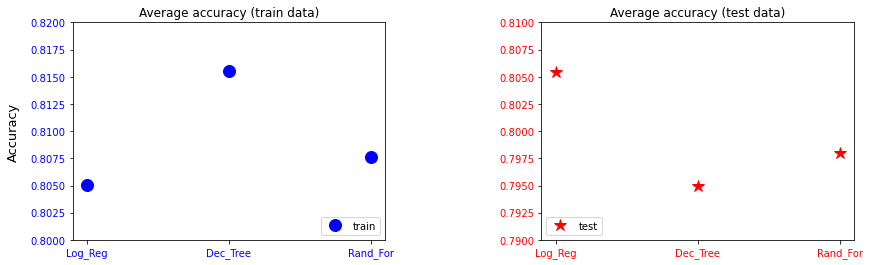

In [138]:
fig, axs = plt.subplots(1,2,figsize = (14,4))
axs[0].plot(meanTrainScores, 'bo', label = 'train', markersize=12)
axs[1].plot(meanTestScores, 'r*', label = 'test', markersize = 12)
fig.text(0.06, 0.5, 'Accuracy', va='center', rotation='vertical', size=13)
#plt.suptitle('Mean accuracy (5 folds)')
axs[0].title.set_text('Average accuracy (train data)')
axs[1].title.set_text('Average accuracy (test data)')
x = np.array([0,1,2])
my_xticks = ['Log_Reg', 'Dec_Tree', 'Rand_For']
plt.sca(axs[0])
plt.xticks(range(3), my_xticks, color='blue')
plt.yticks(color = 'blue')
plt.sca(axs[1])
plt.xticks(range(3), my_xticks, color='red')
plt.yticks(color = 'red')
axs[0].axis(ymin=0.8,ymax=0.82)
axs[1].axis(ymin=0.79,ymax=0.81)
#plt.yticks(np.arange(min(meanTestScores)-0.03, max(meanTestScores)+0.03, 0.02))
axs[0].legend(loc='lower right')
axs[1].legend(loc='lower left')#, bbox_to_anchor=(1.2, 0.87), ncol=1)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

In [140]:
fig.savefig('./images/accuracy_comparison.png')